[View in Colaboratory](https://colab.research.google.com/github/jsedoc/Sharvin-Shah-Spring-2018/blob/master/tree2seq_colab.ipynb)

In [1]:
import sys
print(sys.version_info)

!pip install http://download.pytorch.org/whl/cu90/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip install tqdm nltk
import torch

print(torch.cuda.device_count())
use_cuda = torch.cuda.is_available()
use_cuda = 0

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)
    100% |████████████████████████████████| 633.1MB 54.0MB/s 
    100% |████████████████████████████████| 51kB 4.8MB/s 


1


In [2]:
!rm -r data synth_t2t_data.zip
!wget http://www.seas.upenn.edu/~joao/synth_t2t_data.zip
!unzip synth_t2t_data.zip
!pwd

rm: cannot remove 'data': No such file or directory
rm: cannot remove 'synth_t2t_data.zip': No such file or directory
--2018-05-08 19:25:14--  http://www.seas.upenn.edu/~joao/synth_t2t_data.zip
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10835 (11K) [application/zip]
Saving to: ‘synth_t2t_data.zip’

synth_t2t_data.zip  100%[===================>]  10.58K  --.-KB/s    in 0s      

2018-05-08 19:25:15 (281 MB/s) - ‘synth_t2t_data.zip’ saved [10835/10835]

Archive:  synth_t2t_data.zip
   creating: data/
  inflating: data/train.orig         
/content


In [0]:
from tqdm import tqdm
from copy import deepcopy

PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

MAX_LENGTH = 512


import torch
import torch.utils.data as data

from nltk.tree import Tree

datapath = '/content/data/train.orig'

class Dataset(data.Dataset):

    def __len__(self):
        return self.size

    def read_trees(self, filename):
        with open(filename, 'r') as f:
            trees = [Tree.fromstring(line) for line in tqdm(f.readlines())]
        return trees
    
    def read_seqs(self, filename):
        with open(filename, 'r') as f:
            seqs = [line for line in tqdm(f.readlines())]
        return seqs

In [4]:
dataset = Dataset()
trees = dataset.read_trees('/content/data/train.orig')
# print(trees[1])
# print(len(trees))

100%|██████████| 1000/1000 [00:00<00:00, 27518.43it/s]


In [0]:
# creating a dictionary of unique tokens with the assigned id with file input
def create_vocab(filename):
    vocab = dict()
    with open(filename, 'r') as f:
        for token in f.read().split():
            if token not in vocab:
                vocab[token] = 1
            else:
                vocab[token] += 1
    # print(len(vocab.keys()))    
    index = 0
    token_dict = {}            
    for token in vocab.keys():
        token_dict[token] = index
        index += 1
    
    return token_dict

# fetch id of a token from the dictionary  
def fetch_unique_index(token_dict, token):
    return token_dict[token]

# use dictionary of tokens to form a corresponding one hot representation  
def create_one_hot(token_dict):
    one_hot_dict = {}
    vector_dim = len(token_dict.keys())
    for token in token_dict:    
        tensor = torch.zeros(1, vector_dim)
        tensor = tensor.cuda() if use_cuda else tensor
        tensor[0][token_dict[token]] = 1
        one_hot_dict[token] = tensor
    
    return one_hot_dict

# fetch one hot representation for the token
def fetch_one_hot(one_hot_dict, token):
    return one_hot_dict[token]

In [0]:
vocab = create_vocab(datapath)
# print(vocab)
oh_vocab = create_one_hot(vocab)
# print(fetch_one_hot(oh_vocab, '4'))

In [7]:
dataset = Dataset()
trees = dataset.read_trees(datapath)
seqs = dataset.read_seqs(datapath)
print("\n")
print(trees[0])
print(len(trees[0]))
print(seqs[0]) # maybe the seqs has to be split token wise while training
print(len(seqs[0].split()))

100%|██████████| 1000/1000 [00:00<00:00, 252745.04it/s]



(+ 43 47)
2
( + 43 47 )

5


In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as Var

PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

# module for childsumtreelstm
class ChildSumTreeLSTM(nn.Module):
    def __init__(self, in_dim, mem_dim):
        super(ChildSumTreeLSTM, self).__init__()
        self.in_dim = in_dim
        self.mem_dim = mem_dim
        self.ioux = nn.Linear(self.in_dim, 3 * self.mem_dim)
        self.iouh = nn.Linear(self.mem_dim, 3 * self.mem_dim)
        self.fx = nn.Linear(self.in_dim, self.mem_dim)
        self.fh = nn.Linear(self.mem_dim, self.mem_dim)

    def node_forward(self, inputs, child_c, child_h):
        child_h_sum = torch.sum(child_h, dim=0, keepdim=True)
        # print("dimension of inputs: ", inputs.size())
        # print("dimension of child_h_sum: ", child_h_sum.size())
        iou = self.ioux(inputs) + self.iouh(child_h_sum)
        i, o, u = torch.split(iou, iou.size(1) // 3, dim=1)
        i, o, u = F.sigmoid(i), F.sigmoid(o), F.tanh(u)

        f = F.sigmoid(
            self.fh(child_h) +
            self.fx(inputs).repeat(len(child_h), 1)
        )
        fc = torch.mul(f, child_c)

        c = torch.mul(i, u) + torch.sum(fc, dim=0, keepdim=True)
        h = torch.mul(o, F.tanh(c))
        return c, h

    def forward(self, tree):
      # print(type(tree))
      # print(tree)
      if type(tree) == Tree:
        child_states = []
        for child in tree:
            child_states.append(self.forward(child))
        child_c, child_h = zip(* map(lambda x: x, child_states))
        child_c, child_h = torch.cat(child_c, dim=0), torch.cat(child_h, dim=0)

        if type(tree) == str:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree))
        else:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree.label()))
        state = self.node_forward(node_label_repr, child_c, child_h)
      else:
        # print(type(tree))
        if type(tree) == str:
          node_label_repr = Var(fetch_one_hot(oh_vocab, tree))
        child_c = Var(node_label_repr.data.new(1, self.mem_dim).fill_(0.))
        child_h = Var(node_label_repr.data.new(1, self.mem_dim).fill_(0.))
        state = self.node_forward(node_label_repr, child_c, child_h)
      # Using tree.label() instead of torch.zeros() ensures that the device placement is inherited  

      return state



# module for distance-angle similarity
class Similarity(nn.Module):
  def __init__(self, mem_dim, hidden_dim, num_classes):
    super(Similarity, self).__init__()
    self.mem_dim = mem_dim
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.wh = nn.Linear(2 * self.mem_dim, self.hidden_dim)
    self.wp = nn.Linear(self.hidden_dim, self.num_classes)

  def forward(self, lvec, rvec):
    mult_dist = torch.mul(lvec, rvec)
    abs_dist = torch.abs(torch.add(lvec, -rvec))
    vec_dist = torch.cat((mult_dist, abs_dist), 1)

    out = F.sigmoid(self.wh(vec_dist))
    out = F.log_softmax(self.wp(out), dim=1)
    return out


# putting the whole model together
class SimilarityTreeLSTM(nn.Module):
    def __init__(self, vocab_size, in_dim, mem_dim, hidden_dim, num_classes, sparsity, freeze):
        super(SimilarityTreeLSTM, self).__init__()
        self.emb = nn.Embedding(vocab_size, in_dim, padding_idx=PAD, sparse=sparsity)
        if freeze:
            self.emb.weight.requires_grad = False
        self.childsumtreelstm = ChildSumTreeLSTM(in_dim, mem_dim)
        self.similarity = Similarity(mem_dim, hidden_dim, num_classes)

    def forward(self, ltree, linputs, rtree, rinputs):
        linputs = self.emb(linputs)
        rinputs = self.emb(rinputs)
        lstate, lhidden = self.childsumtreelstm(ltree, linputs)
        rstate, rhidden = self.childsumtreelstm(rtree, rinputs)
        output = self.similarity(lstate, rstate)
        return output

In [9]:
# encoder input size (in_dim) could be anything
# encoder hidden size (mem_dim) would be equal to the dimension of the vector
# encoder hidden size could be anything, decoder hidden size is dependent on final encoder hidden state size
# decoder output size could be anything
cs_treelstm = ChildSumTreeLSTM(71, 128)
print(cs_treelstm)
out = cs_treelstm.forward(trees[1])

ChildSumTreeLSTM(
  (ioux): Linear(in_features=71, out_features=384)
  (iouh): Linear(in_features=128, out_features=384)
  (fx): Linear(in_features=71, out_features=128)
  (fh): Linear(in_features=128, out_features=128)
)


In [10]:
out
out[1]

Variable containing:

Columns 0 to 9 
 0.0358  0.0930  0.1154  0.0396 -0.1045 -0.0595  0.0958  0.0559 -0.0230  0.0133

Columns 10 to 19 
-0.0895 -0.0654 -0.1113 -0.0226 -0.1098  0.1074 -0.0029  0.1695 -0.0420  0.0370

Columns 20 to 29 
-0.0517  0.0470 -0.0488 -0.1034 -0.0320 -0.1457  0.0687 -0.0916 -0.0233 -0.0464

Columns 30 to 39 
-0.1272  0.0352  0.1020 -0.0341  0.0382 -0.0193 -0.0927  0.0438  0.1441 -0.0926

Columns 40 to 49 
-0.0356 -0.0146  0.0404  0.0234 -0.1073 -0.1409 -0.0514  0.2112 -0.0963  0.0031

Columns 50 to 59 
-0.0636  0.0853 -0.0101 -0.0565  0.0211  0.0771 -0.0269  0.0004  0.1228 -0.0375

Columns 60 to 69 
 0.1297 -0.0597 -0.0730  0.1061 -0.0319 -0.0986 -0.0615 -0.1069 -0.0582  0.0817

Columns 70 to 79 
-0.0101  0.0258 -0.1607  0.0293 -0.0078 -0.0716  0.0875 -0.1002  0.0150 -0.1325

Columns 80 to 89 
-0.0814  0.0218  0.0564  0.0146  0.0732 -0.0333 -0.0194  0.0848 -0.0867  0.0368

Columns 90 to 99 
 0.1378 -0.1767  0.0757 -0.0677 -0.0018  0.0396  0.0665 -0.0148 -0.1314

In [0]:
from copy import deepcopy

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        # print("input size: ", input.size())
        # print("input: ", input)
        # print("hidden size: ", hidden.size())
        output = self.embedding(input).view(1, 1, -1)
        # print("After Embedding, size: ", output.size())
        output = F.relu(output)
        # print("output size after ReLU: ", output.size())
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [0]:
def token_to_index(token_dict, filename):
    file_embedding = []
    
    with open(filename, 'r') as f:
        for line in f.readlines()[:2]:
            line_embedding = []
            print("line: ", line)
            tokens = line.split()
            print("tokens: ", tokens)
            for token in tokens:
                line_embedding.append(token_dict[token])
            
            # print("line embedding: ", line_embedding)
            line_tensor = Var(torch.LongTensor(line_embedding).view(-1, 1))
            # print("line tensor: ", line_tensor)
            file_embedding.append(line_tensor)
            # print("file embedding so far: ", file_embedding)
    
    return file_embedding
  
def index_to_token(token_dict, index):
  flipped = {v:k for k,v in token_dict.items()}
  return flipped[index]

In [14]:
token_embedding = token_to_index(vocab, datapath)
token_embedding[1]

line:  ( + 43 47 )

tokens:  ['(', '+', '43', '47', ')']
line:  ( * ( * ( + 55 ( + 56 53 ) ) 31 ) ( - 5 ( * 54 9 ) ) )

tokens:  ['(', '*', '(', '*', '(', '+', '55', '(', '+', '56', '53', ')', ')', '31', ')', '(', '-', '5', '(', '*', '54', '9', ')', ')', ')']


Variable containing:
    0
    5
    0
    5
    0
    1
    6
    0
    1
    7
    8
    4
    4
    9
    4
    0
   10
   11
    0
    5
   12
   13
    4
    4
    4
[torch.LongTensor of size 25x1]

In [15]:
out[1].size()

torch.Size([1, 128])

In [16]:
len(vocab.keys())


71

In [108]:
decoder = DecoderRNN(out[1].size()[1], len(vocab.keys()))
#hidden = decoder.initHidden()
encoder_outputs = out[1]
encoder_outputs = encoder_outputs.unsqueeze(0)
print(encoder_outputs)
for i in range(out[1].size()[1]):
  out, hidden = decoder.forward(token_embedding[1][i], encoder_outputs)

Variable containing:
( 0 ,.,.) = 

Columns 0 to 8 
   0.0830  0.1689  0.0318 -0.1397 -0.0038 -0.0706  0.0213  0.1614 -0.0587

Columns 9 to 17 
  -0.0931  0.0548  0.0766  0.0468  0.0732 -0.0166  0.0309  0.0661 -0.0907

Columns 18 to 26 
   0.0006 -0.0379 -0.1335 -0.1030 -0.1117 -0.0504  0.0564 -0.0604  0.1586

Columns 27 to 35 
   0.0926  0.0237 -0.1079  0.0186  0.0479  0.0664  0.0132  0.0110  0.0554

Columns 36 to 44 
   0.1098  0.0624  0.0983  0.0368  0.0834  0.1237 -0.0494 -0.0429 -0.0051

Columns 45 to 53 
   0.0684  0.0694  0.0025  0.0160  0.0037  0.0386  0.1678 -0.1381  0.0187

Columns 54 to 62 
   0.1585 -0.0172 -0.1612 -0.0808 -0.0173  0.1391 -0.0667 -0.0873 -0.0309

Columns 63 to 71 
   0.1710  0.0919 -0.0500  0.0971  0.0791  0.0108 -0.0330  0.1698 -0.1184

Columns 72 to 80 
   0.1106  0.0485 -0.0872  0.1201 -0.0327 -0.0448  0.1455 -0.0534 -0.0267

Columns 81 to 89 
   0.1757  0.0633  0.0261  0.0735 -0.1394  0.0106  0.0349 -0.0490  0.0656

Columns 90 to 98 
  -0.0044 -0.0799  0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: ignored

In [17]:
out

(Variable containing:
 
 Columns 0 to 9 
  0.0654  0.1790  0.2549  0.0778 -0.2029 -0.1171  0.1855  0.1071 -0.0475  0.0270
 
 Columns 10 to 19 
 -0.1761 -0.1362 -0.2305 -0.0467 -0.2209  0.2212 -0.0055  0.3255 -0.0788  0.0665
 
 Columns 20 to 29 
 -0.1158  0.1034 -0.0904 -0.1996 -0.0638 -0.3460  0.1464 -0.1937 -0.0499 -0.1004
 
 Columns 30 to 39 
 -0.2654  0.0706  0.1868 -0.0719  0.0766 -0.0386 -0.2025  0.0934  0.2570 -0.1799
 
 Columns 40 to 49 
 -0.0691 -0.0300  0.0778  0.0475 -0.2127 -0.2713 -0.1118  0.4069 -0.1838  0.0060
 
 Columns 50 to 59 
 -0.1363  0.1675 -0.0228 -0.1126  0.0414  0.1568 -0.0610  0.0008  0.2702 -0.0764
 
 Columns 60 to 69 
  0.2537 -0.1130 -0.1514  0.2218 -0.0616 -0.1887 -0.1184 -0.2041 -0.1128  0.1782
 
 Columns 70 to 79 
 -0.0204  0.0477 -0.3464  0.0624 -0.0142 -0.1378  0.1687 -0.2240  0.0304 -0.2507
 
 Columns 80 to 89 
 -0.1572  0.0455  0.1084  0.0264  0.1296 -0.0686 -0.0393  0.2026 -0.1832  0.0717
 
 Columns 90 to 99 
  0.3047 -0.3326  0.1411 -0.1362 -0.0039 

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
from torch import optim

tree_variable = trees
target_variable = token_embedding

input_size = len(vocab.keys()) # here also equal to length of output vocab
hidden_size = 128 # any size can be given here
output_size = input_size

encoder = ChildSumTreeLSTM(input_size, hidden_size)
decoder = DecoderRNN(hidden_size, output_size)

if use_cuda:
  encoder = encoder.cuda()
  decoder = decoder.cuda()

learning_rate = 0.0005
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

MAX_LENGTH = max([len(i) for i in seqs])

# only one example at a time, needs to be called in an iterative fashion
def train(tree_variable, target_variable, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, 
          criterion, max_length=MAX_LENGTH):
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  # print("tree variable: ", tree_variable)
  # print("target variable: ", target_variable)
  input_length = len(tree_variable)
  # print("input_length: ", input_length)
  target_length = len(target_variable)
  # print("target_length: ", target_length)
  encoder_outputs = Var(torch.zeros(max_length, encoder.mem_dim))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
  
  loss = 0

  predicted = []
  
  # encode tree
  # print("Encoding begins......")
  #for ei in range(input_length):
    # print("input variable ei size: ", len(input_variable[ei]))
#   encoder_states = encoder(input_variable[ei])
#   encoder_outputs[ei] = encoder_states[0]
  encoder_states = encoder(input_variable)
  encoder_outputs = encoder_states[0]
    
  # decoder serial and accumulate loss

  decoder_input = Var(torch.LongTensor([[0]]))
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input  
  # print("decoder input: ", decoder_input)
  decoder_hidden = encoder_states[1]
  # print("before unsqueeze: ", decoder_hidden.size())
  decoder_hidden = decoder_hidden.unsqueeze(0)
  # print("after unsqueeze: ", decoder_hidden.size())
  use_teacher_forcing = True 

  if use_teacher_forcing:
    # print("Decoding begins...")
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
      target_var = Var(torch.LongTensor([[fetch_unique_index(vocab, target_variable[di])]]))
      target_var = target_var.cuda() if use_cuda else target_var
      # print("variable: ", target_var)
      # print("current element: ", target_variable[di])
      # current_target = Var(fetch_one_hot(oh_vocab, target_variable[di]))
      # target_variable[di] = token_embedding[di]
      # print("one hot representation: ", current_target)
      #import pdb;pdb.set_trace()
      loss += criterion(decoder_output, target_var[0][0])
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]
      predicted.append(ni)
      decoder_input = target_var  # Teacher forcing

  # call backward

  loss.backward()

  # update parameters
  
  encoder_optimizer.step()
  decoder_optimizer.step()

  return (loss.data[0] / target_length, predicted)


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  # this locator puts ticks at regular intervals
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

print_every = 100
plot_every = 100
start = time.time()
plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
n_iters = 50

iteration_count = 0

for k in range(n_iters):
  for i in range(len(trees)):
    iteration_count += 1
    input_variable = trees[i]

    target_variable = seqs[i].split()

    loss, predicted = train(input_variable, target_variable, encoder,
                            decoder, encoder_optimizer, decoder_optimizer, criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if (i+1) % print_every == 0:
      print('input: ', trees[i])
      print('target: ', seqs[i][:-1])
      print('pred: ', " ".join([index_to_token(vocab, x) for x in predicted]))
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print('iterations: %d, time elapsed: %s, loss:%.4f' % (iteration_count, timeSince(start, i / (n_iters)),
                                     print_loss_avg))

    if (i+1) % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      print(len(plot_losses))
      plot_loss_total = 0  

#showPlot(plot_losses)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input:  (+ 28 53)
target:  ( + 28 53 )
pred:  ( ( ( ( )
iterations: 100, time elapsed: 0m 2s (- -1m 58s), loss:3.1685
1
input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( ( ( + ( + ( + ( ) ) ) ) ) + ( ) ) ) ) + ( + ( ) ) ) ) )
iterations: 200, time elapsed: 0m 5s (- -1m 55s), loss:2.5068
2
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( + ( + ( ( ) ( + ( ( + ( + ( ) ) ) ) ) )
iterations: 300, time elapsed: 0m 7s (- -1m 53s), loss:2.1802
3
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( + ( ( + ( + ( + ( ( ) ) ) ( ) (
iterations: 400, time elapsed: 0m 10s (- -1m 50s), loss:2.0279
4
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( - ( ( * 61 61 ) )
iterations: 500, time elapsed: 0m 13s (- -1m 47s), loss:1.9467
5
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( / 60 60 )
iter

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( + ( - ( + ( + 61 60 ) 60 ) ( + 59 ( ) ) ( + ( - 59 59 ) ( ) )
iterations: 3200, time elapsed: 1m 33s (- -2m 49s), loss:1.7033
32
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( - ( - ( ( ) ( - ( ( - ( - 59 60 ) ) ) ) )
iterations: 3300, time elapsed: 1m 36s (- -2m 39s), loss:1.6995
33
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( * ( * ( * 51 55 ) ( ) ( ) )
iterations: 3400, time elapsed: 1m 39s (- -2m 33s), loss:1.6991
34
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( - ( ( * 53 ( ) )
iterations: 3500, time elapsed: 1m 42s (- -2m 27s), loss:1.6303
35
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( / 50 60 )
iterations: 3600, time elapsed: 1m 45s (- -2m 23s), loss:1.6398
36
input:  (/ (* 61 (* 62 (* 63 17))) (- 

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( - ( - ( - ( - 62 60 ) 60 ) ( + 59 59 ) ) ( * ( + 59 59 ) ( ) )
iterations: 6200, time elapsed: 3m 2s (- -3m 43s), loss:1.4257
62
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( + ( - ( ( ) ( * ( ( * ( - 59 60 ) 59 ) ) )
iterations: 6300, time elapsed: 3m 5s (- -3m 25s), loss:1.4079
63
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( * ( * ( * 51 52 ) 51 ) ( ) )
iterations: 6400, time elapsed: 3m 7s (- -3m 15s), loss:1.4347
64
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( + 50 45 ) )
iterations: 6500, time elapsed: 3m 10s (- -3m 8s), loss:1.3720
65
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 50 50 )
iterations: 6600, time elapsed: 3m 13s (- -3m 2s), loss:1.3736
66
input:  (/ (* 61 (* 62 (* 63 17))) (- (

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( - 62 58 ) 60 ) ( - 59 59 ) ) ( - ( - 58 59 ) ( ) )
iterations: 9200, time elapsed: 4m 33s (- -4m 35s), loss:1.1961
92
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - ( ( ) ( - ( ( * ( - 60 60 ) 59 ) ) )
iterations: 9300, time elapsed: 4m 36s (- -4m 9s), loss:1.1766
93
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( / ( * ( / 51 45 ) 51 ) ( ) )
iterations: 9400, time elapsed: 4m 39s (- -5m 55s), loss:1.2371
94
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 50 45 ) )
iterations: 9500, time elapsed: 4m 42s (- -5m 45s), loss:1.1970
95
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 50 26 )
iterations: 9600, time elapsed: 4m 45s (- -5m 38s), loss:1.1707
96
input:  (/ (* 61 (* 62 (* 63 17))) 

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( - 60 59 ) 60 ) ( - 59 59 ) ) ( - ( - 58 2 ) ( ) )
iterations: 12200, time elapsed: 6m 6s (- -5m 25s), loss:1.0187
122
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - ( 61 ) ( + ( ( - ( - 60 60 ) 59 ) ) )
iterations: 12300, time elapsed: 6m 8s (- -6m 52s), loss:1.0411
123
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * ( ( / ( * ( * 4 54 ) 54 ) ( ) )
iterations: 12400, time elapsed: 6m 11s (- -6m 34s), loss:1.0927
124
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 50 45 ) )
iterations: 12500, time elapsed: 6m 14s (- -6m 22s), loss:1.0470
125
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 12600, time elapsed: 6m 17s (- -6m 13s), loss:1.0275
126
input:  (/ (* 61 (* 62 (* 6

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( - 61 58 ) 60 ) ( - 59 59 ) ) ( - ( - 58 2 ) ( ) )
iterations: 15200, time elapsed: 7m 38s (- -6m 16s), loss:0.8720
152
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + ( ( * ( - 60 60 ) 59 ) ) )
iterations: 15300, time elapsed: 7m 40s (- -7m 36s), loss:0.8659
153
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 51 45 ) 45 ) 48 ) )
iterations: 15400, time elapsed: 7m 43s (- -7m 14s), loss:0.9144
154
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 48 45 ) )
iterations: 15500, time elapsed: 7m 46s (- -7m 0s), loss:0.9135
155
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 15600, time elapsed: 7m 49s (- -8m 49s), loss:0.8910
156
input:  (/ (* 61 (* 62

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( - 61 56 ) 60 ) ( - 59 59 ) ) ( - ( - 57 2 ) 57 ) )
iterations: 18200, time elapsed: 9m 9s (- -7m 8s), loss:0.7374
182
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + ( ( - ( - 60 60 ) 59 ) ) )
iterations: 18300, time elapsed: 9m 11s (- -8m 20s), loss:0.7457
183
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 44 45 ) 45 ) 43 ) )
iterations: 18400, time elapsed: 9m 14s (- -9m 54s), loss:0.7897
184
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 7 45 ) )
iterations: 18500, time elapsed: 9m 18s (- -9m 37s), loss:0.7996
185
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 18600, time elapsed: 9m 21s (- -9m 25s), loss:0.7762
186
input:  (/ (* 61 (* 62 

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( / 61 56 ) 60 ) ( - 59 59 ) ) ( - 58 - 23 2 ) 57 ) )
iterations: 21200, time elapsed: 10m 41s (- -9m 59s), loss:0.6314
212
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( - 58 ( - ( - 60 60 ) 59 ) ) )
iterations: 21300, time elapsed: 10m 44s (- -9m 3s), loss:0.6412
213
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 51 45 ) 45 ) 43 ) )
iterations: 21400, time elapsed: 10m 46s (- -10m 34s), loss:0.6701
214
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 44 45 ) )
iterations: 21500, time elapsed: 10m 50s (- -10m 15s), loss:0.6882
215
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 21600, time elapsed: 10m 53s (- -10m 1s), loss:0.6560
216
input:  (/ (

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( * ( / 61 35 ) 60 ) ( - 59 59 ) ) ( - 58 - 58 2 ) 57 ) )
iterations: 24200, time elapsed: 12m 13s (- -10m 50s), loss:0.5263
242
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( * 59 59 ) 59 ) ) )
iterations: 24300, time elapsed: 12m 16s (- -11m 46s), loss:0.5330
243
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 44 28 ) 45 ) 43 ) )
iterations: 24400, time elapsed: 12m 19s (- -11m 13s), loss:0.5618
244
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 44 45 ) )
iterations: 24500, time elapsed: 12m 22s (- -12m 51s), loss:0.5702
245
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 24600, time elapsed: 12m 25s (- -12m 36s), loss:0.5629
246
input:  

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( - ( - ( / 62 35 ) 60 ) ( - 59 59 ) ) ( - ( - 58 7 ) 57 ) )
iterations: 27200, time elapsed: 13m 45s (- -11m 41s), loss:0.4308
272
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( - 60 60 ) 59 ) ) )
iterations: 27300, time elapsed: 13m 48s (- -12m 30s), loss:0.4623
273
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 47 28 ) 45 ) 43 ) )
iterations: 27400, time elapsed: 13m 51s (- -13m 52s), loss:0.4880
274
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 44 33 ) )
iterations: 27500, time elapsed: 13m 54s (- -13m 29s), loss:0.4849
275
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 27600, time elapsed: 13m 57s (- -13m 12s), loss:0.4581
276
input:  (

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( / 61 33 ) 60 ) ( - 59 59 ) ) ( - ( - 58 2 ) 35 ) )
iterations: 30200, time elapsed: 15m 19s (- -12m 31s), loss:0.3459
302
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( - 60 60 ) 59 ) ) )
iterations: 30300, time elapsed: 15m 22s (- -13m 11s), loss:0.3806
303
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 47 28 ) 45 ) 43 ) )
iterations: 30400, time elapsed: 15m 25s (- -14m 30s), loss:0.4073
304
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + ( ( / 44 33 ) )
iterations: 30500, time elapsed: 15m 28s (- -14m 4s), loss:0.4121
305
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 30600, time elapsed: 15m 31s (- -15m 46s), loss:0.3846
306
input:  (/

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( / 61 33 ) 60 ) ( - 59 59 ) ) ( - ( - 58 2 ) 35 ) )
iterations: 33200, time elapsed: 16m 53s (- -13m 21s), loss:0.2995
332
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( - 16 60 ) 59 ) ) )
iterations: 33300, time elapsed: 16m 56s (- -15m 53s), loss:0.3118
333
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 51 28 ) 45 ) 43 ) )
iterations: 33400, time elapsed: 16m 59s (- -15m 8s), loss:0.3470
334
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 38 ( / 44 33 ) )
iterations: 33500, time elapsed: 17m 2s (- -16m 39s), loss:0.3577
335
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 29 26 )
iterations: 33600, time elapsed: 17m 5s (- -16m 19s), loss:0.3502
336
input:  (/ 

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( * 61 56 ) 60 ) ( - 59 59 ) ) ( - 58 - 58 16 ) 57 ) )
iterations: 36200, time elapsed: 18m 27s (- -14m 10s), loss:0.2486
362
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( - 4 60 ) 59 ) ) )
iterations: 36300, time elapsed: 18m 30s (- -16m 34s), loss:0.2766
363
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 46 ( / ( * ( * 46 28 ) 45 ) 43 ) )
iterations: 36400, time elapsed: 18m 33s (- -17m 45s), loss:0.2865
364
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 38 ( / 44 33 ) )
iterations: 36500, time elapsed: 18m 36s (- -17m 15s), loss:0.2897
365
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 36600, time elapsed: 18m 40s (- -18m 53s), loss:0.2622
366
input: 

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( * 61 33 ) 60 ) ( - 59 59 ) ) ( - ( * 58 16 ) 57 ) )
iterations: 39200, time elapsed: 20m 2s (- -16m 59s), loss:0.2168
392
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 59 61 ) ( + 58 ( * ( - 16 60 ) 59 ) ) )
iterations: 39300, time elapsed: 20m 4s (- -17m 16s), loss:0.2536
393
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
iterations: 39400, time elapsed: 20m 7s (- -18m 23s), loss:0.2335
394
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 20 ( / 44 33 ) )
iterations: 39500, time elapsed: 20m 10s (- -19m 50s), loss:0.2351
395
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 39600, time elapsed: 20m 14s (- -19m 27s), loss:0.2129
396
input:  (/

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( / 62 29 ) 60 ) ( - 59 59 ) ) ( - ( - 57 7 ) 35 ) )
iterations: 42200, time elapsed: 21m 35s (- -17m 49s), loss:0.1970
422
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 34 61 ) ( + 58 ( * ( - 60 60 ) 59 ) ) )
iterations: 42300, time elapsed: 21m 38s (- -19m 58s), loss:0.2235
423
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
iterations: 42400, time elapsed: 21m 41s (- -19m 1s), loss:0.2077
424
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 20 ( / 44 33 ) )
iterations: 42500, time elapsed: 21m 44s (- -20m 26s), loss:0.2053
425
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 42600, time elapsed: 21m 47s (- -20m 1s), loss:0.2120
426
input:  (/

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 59 59 ) ) ( - ( - 58 16 ) 35 ) )
iterations: 45200, time elapsed: 23m 8s (- -18m 40s), loss:0.1538
452
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 21 61 ) ( + 58 ( * ( * 1 60 ) 59 ) ) )
iterations: 45300, time elapsed: 23m 10s (- -20m 41s), loss:0.1660
453
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
iterations: 45400, time elapsed: 23m 13s (- -21m 40s), loss:0.1499
454
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 20 ( / 44 33 ) )
iterations: 45500, time elapsed: 23m 16s (- -21m 3s), loss:0.1508
455
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 45600, time elapsed: 23m 20s (- -22m 36s), loss:0.1401
456
input:  (/

input:  (* (+ (* (/ 61 56) 60) (- 49 59)) (- (- 58 16) 35))
target:  ( * ( + ( * ( / 61 56 ) 60 ) ( - 49 59 ) ) ( - ( - 58 16 ) 35 ) )
pred:  ( * ( + ( * 61 / 62 56 ) 60 ) ( - 59 59 ) ) ( - ( - 58 9 ) 35 ) )
iterations: 48200, time elapsed: 24m 41s (- -19m 30s), loss:0.1290
482
input:  (/ (- 21 61) (+ 58 (* (- 1 60) 59)))
target:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
pred:  ( / ( - 21 61 ) ( + 58 ( * ( - 1 60 ) 59 ) ) )
iterations: 48300, time elapsed: 24m 44s (- -21m 23s), loss:0.1475
483
input:  (* 44 (/ (* (* 46 28) 45) 43))
target:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
pred:  ( * 44 ( / ( * ( * 46 28 ) 45 ) 43 ) )
iterations: 48400, time elapsed: 24m 47s (- -22m 18s), loss:0.1346
484
input:  (+ 20 (/ 44 33))
target:  ( + 20 ( / 44 33 ) )
pred:  ( + 20 ( / 44 33 ) )
iterations: 48500, time elapsed: 24m 50s (- -23m 38s), loss:0.1369
485
input:  (- 27 26)
target:  ( - 27 26 )
pred:  ( - 27 26 )
iterations: 48600, time elapsed: 24m 53s (- -23m 10s), loss:0.1230
486
input:  

In [43]:
plot_losses

[3.1358604092323907,
 2.4798466121405744,
 2.1829839828936906,
 2.0207086094328934,
 1.9374887960831129,
 1.9132841800834166,
 1.874429765340961,
 1.8498487332204467,
 1.8501366840394895,
 1.8147136895450928,
 1.8631806132914923,
 1.8415996782796324,
 1.8439749138368777,
 1.8424965850418444,
 1.7772972113850352,
 1.7787637731195103,
 1.75906500170459,
 1.7320625701786831,
 1.7523405333061959,
 1.7331612496005693,
 1.787572320165006,
 1.7685080344291888,
 1.7604820216992252,
 1.775063229755782,
 1.7126976078629017,
 1.711193128720876,
 1.7053899086812399,
 1.6703249421240685,
 1.68568569201647,
 1.665086590089697,
 1.7086184281632368,
 1.6943187070985646,
 1.6815293326041287,
 1.688728402185536,
 1.6350277772279682,
 1.6222610677641356,
 1.592364416667527,
 1.580149739164745,
 1.5859348325428877,
 1.5719173455408628,
 1.6149052803091926,
 1.5949718463850096,
 1.5725795041848358,
 1.5745066117381168,
 1.529285365422285,
 1.5098316572440158,
 1.4881685815488697,
 1.470775569422221,
 1.471

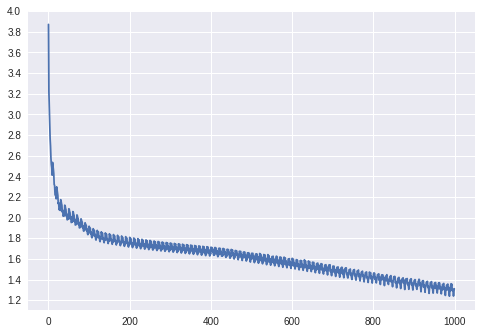

In [45]:
showPlot(plot_losses)